In [1]:
import xarray as xr 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import dask.array as da
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import os
from helper import concatenate_images2



In [2]:
infiles = os.listdir('../../../data/cluster/input_sam')
infiles.sort()

infiles = [f'../../../data/cluster/input_sam/{f}' for f in infiles]
infiles

outfiles = os.listdir('../../../data/cluster/output_sam')
outfiles.sort()

outfiles = [f'../../../data/cluster/output_sam/{f}' for f in outfiles if 'full' in f and 'T' in f]
outfiles

outfiles = os.listdir('../../../data/cluster/output_sam')
#outfiles = os.listdir('../../../data/full_datasets')
outfiles.sort()

outfiles = [f'../../../data/cluster/output_sam/{f}' for f in outfiles if 'full' in f and 'T' in f]
#outfiles = [f'../../../data/full_datasets/{f}' for f in outfiles if 'full' in f and 'T' in f]
outfiles.sort()


../../../data/cluster/output_sam/2022-04-04T13:19:30_2022-04-04T13:40:00_full.nc


/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


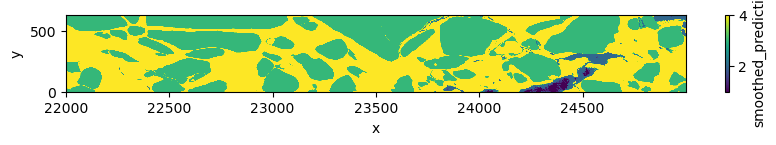

In [3]:
ds_concat = xr.open_dataset(infiles[-2], engine='netcdf4')
ds_sam = xr.open_dataset(outfiles[-2], engine='netcdf4')
print(outfiles[-2])

ds_sam.smoothed_prediction.isel(x=slice(22000, 25000)).rolling(x=2, y=2).mean().plot(figsize=(10, 1))    

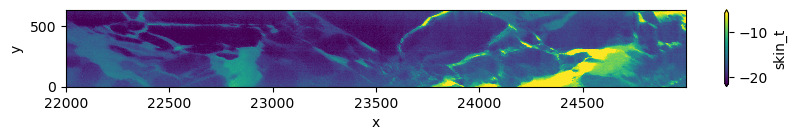

In [4]:
ds_sam.isel(x=slice(22000, 25000)).skin_t.plot(robust=True, figsize=(10, 1))

In [4]:
ds_raw_bt5 = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-04-04_v_0.1.zarr', engine='zarr').sel(time=slice('2022-04-04T13:19:30', '2022-04-04T13:40:00'))
ds_raw_bt6 = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-04-04_v_0.1.zarr', engine='zarr').sel(time=slice('2022-04-04T13:19:30', '2022-04-04T13:40:00'))


In [8]:
ds_raw = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/Mueller_et_al_2024/data/predicted/pushbroom/v_0.2/2022-04-04T13:19:30_2022-04-04T13:40:00.nc', engine='h5netcdf')
ds_raw['quality_flag'] = ds_raw.BT_1.isnull().sum(dim=('x', 'y')) == 0 

from skimage.measure import label

#BT1 = concatenate_images2(ds_raw, variable='BT_1'
BT5 = concatenate_images2(ds_raw_bt5, variable='BT_2D', slicing_position=250, channel=3)
BT6 = concatenate_images2(ds_raw_bt6, variable='BT_2D', slicing_position=250, channel=4)

im = concatenate_images2(ds_raw, slicing_position=250, variable='BT_1')
im = im.astype(np.float32)
im = np.pad(im, ((0, 0), (250, 0)), mode='constant', constant_values=np.nan)
im = np.pad(im, ((0, 0), (0, 230)), mode='constant', constant_values=np.nan)


ds_sam['BT_1'] = xr.DataArray(im, dims=( 'y', 'x'), coords={ 'y': ds_sam.y, 'x': ds_sam.x})#.interpolate_na(dim='x', method='linear')
ds_sam['old_prediction'] = ds_sam['pred_proba'].argmax(dim='surface_class')
ds_sam['BT_1'] = ds_sam['BT_1'].interpolate_na(dim='x', method='linear')
mapping_dict = {0: 1, 1: 3, 2: 4}

BT5 = np.pad(BT5, ((0, 0), (250, 0)), mode='constant', constant_values=np.nan)
BT5 = np.pad(BT5, ((0, 0), (0, 230)), mode='constant', constant_values=np.nan)
BT6 = np.pad(BT6, ((0, 0), (250, 0)), mode='constant', constant_values=np.nan)
BT6 = np.pad(BT6, ((0, 0), (0, 230)), mode='constant', constant_values=np.nan)

ds_sam['BT_5'] = xr.DataArray(BT5, dims=( 'y', 'x'), coords={ 'y': ds_sam.y, 'x': ds_sam.x})
ds_sam['BT_6'] = xr.DataArray(BT6, dims=( 'y', 'x'), coords={ 'y': ds_sam.y, 'x': ds_sam.x})

ds_sam['BT_5'] = ds_sam['BT_5'].interpolate_na(dim='x', method='linear')
ds_sam['BT_6'] = ds_sam['BT_6'].interpolate_na(dim='x', method='linear')
ds_start = '2022-04-04T13:19:30'
ds_stop =  '2022-04-04T13:40:00'

ds_sam['time'] = pd.date_range(ds_start, ds_stop, len(ds_sam.x))
ds_sam['time'] = ('x', ds_sam.time.values)

# Define a function to apply the mapping
def map_values(x):
    mapping_dict = {0: 1, 1: 4, 2: 3}
    return np.vectorize(mapping_dict.get)(x)

# Use apply_ufunc to apply the mapping to the DataArray
ds_sam['old_prediction'] = xr.apply_ufunc(map_values, ds_sam['old_prediction'])

# Assuming 'image' is your input data
image = ds_sam['smoothed_prediction']
seg = label(image.to_numpy(), background=4)
seg2 = ds_sam['segmentation'].to_numpy()

ds_sam['skimage_seg'] = xr.DataArray(seg, dims=('y', 'x'))

ds = ds_sam.isel(x=slice(22000, 25000))


In [9]:
ds_sam.to_netcdf('../../../data/data_to_plot_and_animate.nc', mode='w')

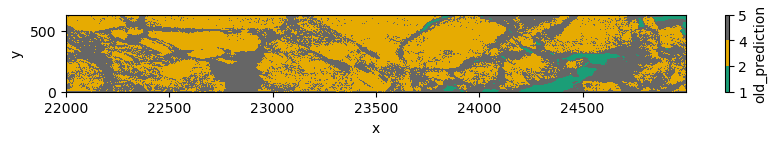

In [8]:

from matplotlib.colors import BoundaryNorm, ListedColormap

colors = np.array([[0.10588235, 0.61960784, 0.46666667, 1.],
                #[0.45882353, 0.43921569, 0.70196078, 1.],
                [0.90196078, 0.67058824, 0.00784314, 1.],
                [0.4       , 0.4       , 0.4       , 1.],

])

cmap = ListedColormap(colors)
#cmap = plt.get_cmap('Dark2')
bounds = [1, 2, 4, 5]
norm = BoundaryNorm(bounds, cmap.N)

ds['old_prediction'].plot(cmap=cmap, norm=norm, figsize=(10, 1))

<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_702851/4236210320.py:43: SyntaxWarning: invalid escape sequence '\m'
  cbar = fig.colorbar(im, cax=cax, orientation='vertical', label='$T_\mathrm{B,1}$ (°C)', ticks=[-20, -15, -10, -5])


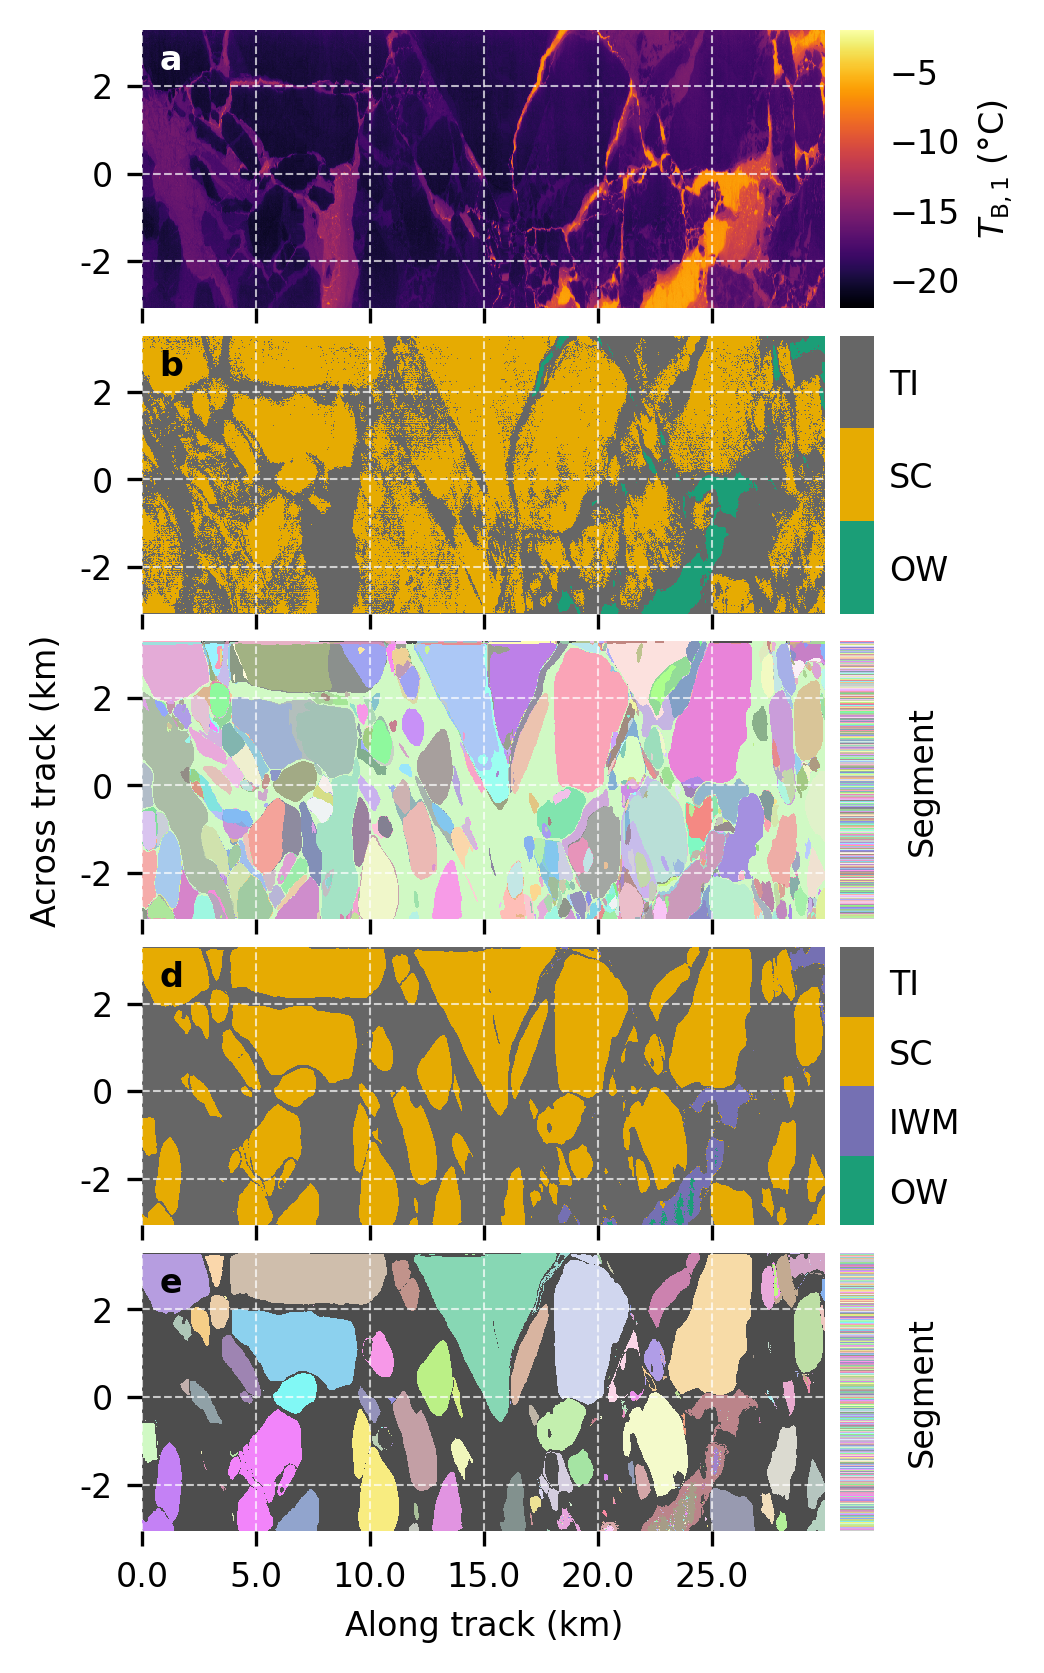

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from skimage.measure import label
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import json

plt.rcParams.update(json.load(open('/projekt_agmwend/home_rad/Joshua/MasterArbeit/plot_settings.json')))


fs = 8
plt.rcParams['font.size'] = fs
plt.rcParams['axes.titlesize'] = fs
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['legend.fontsize'] = fs
plt.rcParams['figure.titlesize'] = fs


# Generate random RGB values for each segment
def random_cmap(nlabels, seed=12):
    np.random.seed(seed)
    rand_colors = np.random.rand(nlabels, 3)
    pastel_colors = (rand_colors + np.ones((nlabels, 3))) / 2  # Blend with white for pastel
    pastel_colors[0] = [0.3, 0.3, 0.3]  # Set background (label 0) to a light gray
    return ListedColormap(pastel_colors)

# Assuming 'image' is your input data
image = ds['smoothed_prediction']
seg = label(image.to_numpy(), background=4)
seg2 = ds['segmentation'].to_numpy()

ds['skimage_seg'] = xr.DataArray(seg, dims=('y', 'x'))

fig, ax = plt.subplots(5, 1, figsize=(3.15, 6.5), sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

im = ds['BT_1'].plot(ax=ax[0], cmap='inferno', add_colorbar=False, vmin=-2, vmax=-20)  
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', label='$T_\mathrm{B,1}$ (°C)', ticks=[-20, -15, -10, -5])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(which='both', length=0)
cbar.ax.grid(False)

# Plot 1: Old prediction contour
im = ds['old_prediction'].plot(cmap=cmap, norm=norm, add_colorbar=False, ax=ax[1])
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[1.5, 3, 4.5])
cbar.set_ticklabels(['OW', 'SC', 'TI'])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(which='both', length=0)
cbar.ax.grid(False)

# Plot 4: Skimage segmentation with random colors
n_labels = int(seg2.max()) + 1  # Number of labels
random_rgb_cmap = random_cmap(n_labels)
im = ds['segmentation'].plot(cmap=random_rgb_cmap, add_colorbar=False, ax=ax[2])
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=np.arange(0, n_labels, 1000), label='Segment')
cbar.set_ticklabels([])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(which='both', length=0)

# Plot 3: Smoothed prediction contour
im = ds['smoothed_prediction'].plot.contourf(levels=[0.5, 1.5, 2.5, 3.5, 4.5], cmap='Dark2', add_colorbar=False, ax=ax[3])
divider = make_axes_locatable(ax[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[1, 2, 3, 4])
cbar.set_ticklabels(['OW', 'IWM', 'SC', 'TI'])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(which='both', length=0)
cbar.ax.grid(False)

# Plot 4: Skimage segmentation with random colors
n_labels = seg.max() + 1  # Number of labels
random_rgb_cmap = random_cmap(n_labels)
im = ds['skimage_seg'].plot(cmap=random_rgb_cmap, add_colorbar=False, ax=ax[4])
divider = make_axes_locatable(ax[4])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', label='Segment')
cbar.set_ticklabels([])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(which='both', length=0)

y_ticks = np.array([306-300, 306-200, 306-100, 306, 306+100, 306+200, 306+300])
y_labels = np.array([-3, -2, -1, 0, 1, 2, 3])
y_ticks = np.array([306-200, 306,306+200])
y_labels = np.array([-2, 0, 2])

x_ticks_major = np.arange(22000, 25000, 500)
x_ticklabels = (x_ticks_major - 22000) / 100

for a in ax:
    a.set_yticks(y_ticks)
    a.set_yticklabels(y_labels)
    a.set_xticks(x_ticks_major)
    a.set_xticklabels(x_ticklabels)
    a.set_ylabel('')
    a.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    a.grid(True, axis='both', linestyle='--', alpha=0.7, color='w', zorder=111)
### add the a,b,c,d labels

fs = 8

ax[0].text(.025, .95, 'a', transform=ax[0].transAxes, fontsize=fs, fontweight='bold', va='top', color='w')
ax[1].text(.025, .95, 'b', transform=ax[1].transAxes, fontsize=fs, fontweight='bold', va='top')

ax[3].text(.025, .95, 'd', transform=ax[3].transAxes, fontsize=fs, fontweight='bold', va='top')
ax[4].text(.025, .95, 'e', transform=ax[4].transAxes, fontsize=fs, fontweight='bold', va='top')

ax[-1].set_xlabel('Along track (km)')
ax[2].set_ylabel('Across track (km)')  
#fig.supylabel('Across track (km)', x=0.05, y=0.5, rotation=90, fontsize=10)

#ax.axes.grid(True, axis='both', linestyle='--', alpha=0.7, color='w')
plt.savefig('../../../plots/methods_flowchart_andre_v5.png', bbox_inches='tight', dpi=300)

In [33]:
ds.to_netcdf('../../../data/stable_concating_plot_data.nc', engine='netcdf4')

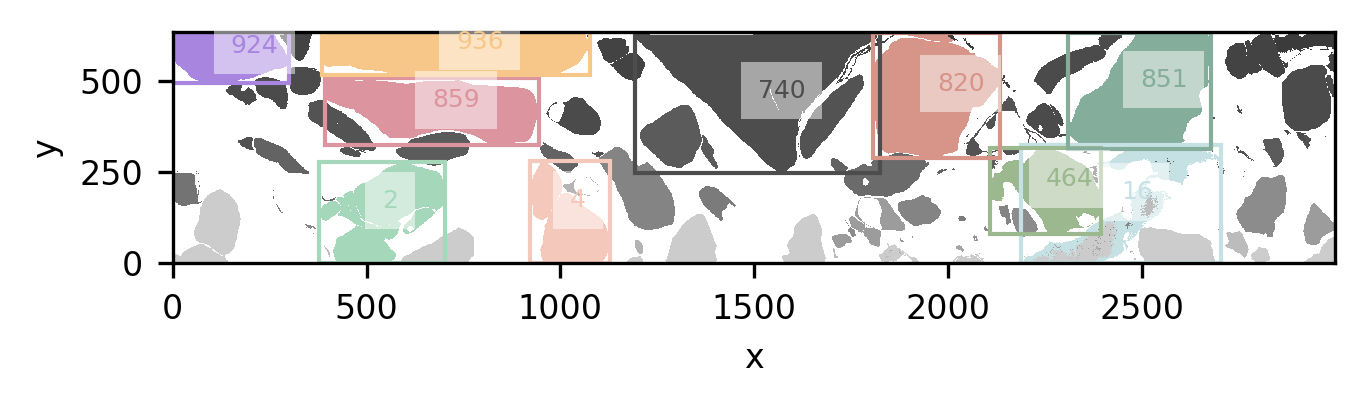

In [10]:
# Plot 4: Skimage segmentation with 10 largest segments in color, others in grayscale

import cmocean
from collections import Counter
from skimage.measure import regionprops
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(1, 1, figsize=(5, 1))

seg = ds['skimage_seg'].to_numpy()
# Compute counts of labels
counts = Counter(seg.flatten())
counts.pop(0, None)  # Remove background label 0

# Get labels of the 10 largest segments
largest_labels = [label for label, count in counts.most_common(10)]
other_labels = set(np.unique(seg)) - set([0]) - set(largest_labels)
n_other_labels = len(other_labels)

# Create label to colormap index mapping
label_to_cmap_index = {0: 0}  # Background label
for idx, label in enumerate(largest_labels, start=1):
    label_to_cmap_index[label] = idx

# Assign grayscale indices to other labels
N_grayscale = 20
grayscale_indices = np.linspace(len(largest_labels)+1, len(largest_labels)+N_grayscale, n_other_labels, dtype=int)
for label, grayscale_idx in zip(sorted(other_labels), grayscale_indices):
    label_to_cmap_index[label] = grayscale_idx

# Create the colormap
cmap_size = len(largest_labels) + N_grayscale + 1
colors = np.zeros((cmap_size, 3))

# Background color
colors[0] = [1, 1, 1]  # White

# Colors for largest segments
# largest_label_colors = cmocean.cm.ice(np.linspace(0, 1, len(largest_labels)))
largest_label_colors = random_cmap(len(largest_labels), seed=16).colors

for idx in range(len(largest_labels)):
    colors[idx+1] = largest_label_colors[idx][:3]

# Grayscale colors for other segments
grayscale_colors = np.linspace(0.8, 0.2, N_grayscale)
for idx in range(N_grayscale):
    colors[len(largest_labels)+1 + idx] = [grayscale_colors[idx]] * 3

cmap = ListedColormap(colors)
#cmap = ListedColormap(grayscale_colors)

# Map 'seg' to 'seg_mapped'
max_label = seg.max()
label_map = np.zeros(max_label + 1, dtype=int)
for label, idx in label_to_cmap_index.items():
    label_map[label] = idx
seg_mapped = label_map[seg]

# Plot the segmentation
seg_mapped_da = xr.DataArray(seg_mapped, dims=('y', 'x'))
im = seg_mapped_da.plot(cmap=cmap, add_colorbar=False, ax=ax)

# Mark the extent of the 10 largest segments
regions = regionprops(seg)
for region in regions:
    label = region.label
    if label in largest_labels:
        minr, minc, maxr, maxc = region.bbox
        edgecolor = colors[label_to_cmap_index[label]]
        rect = Rectangle((minc, minr), maxc - minc, maxr - minr, 
                         edgecolor=edgecolor, facecolor='none', linewidth=1)
        ax.add_patch(rect)
        ### write the label number
        x_text = minc + (maxc - minc) / 2
        y_text = minr + (maxr - minr) / 2

        ax.text(x_text, y_text, label, color=edgecolor, fontsize=6, ha='left', va='bottom', bbox=dict(facecolor='w', edgecolor='none', alpha=0.5))


4076
{37: 1, 2208: 2, 2007: 3, 88: 4, 15: 5, 2409: 6, 25: 7, 3298: 8, 2748: 9, 794: 10, 2308: 11, 3193: 12}
12
974
{0: 1, 740: 2, 851: 3, 820: 4, 936: 5, 859: 6, 2: 7, 464: 8, 4: 9, 924: 10, 16: 11, 491: 12}
12


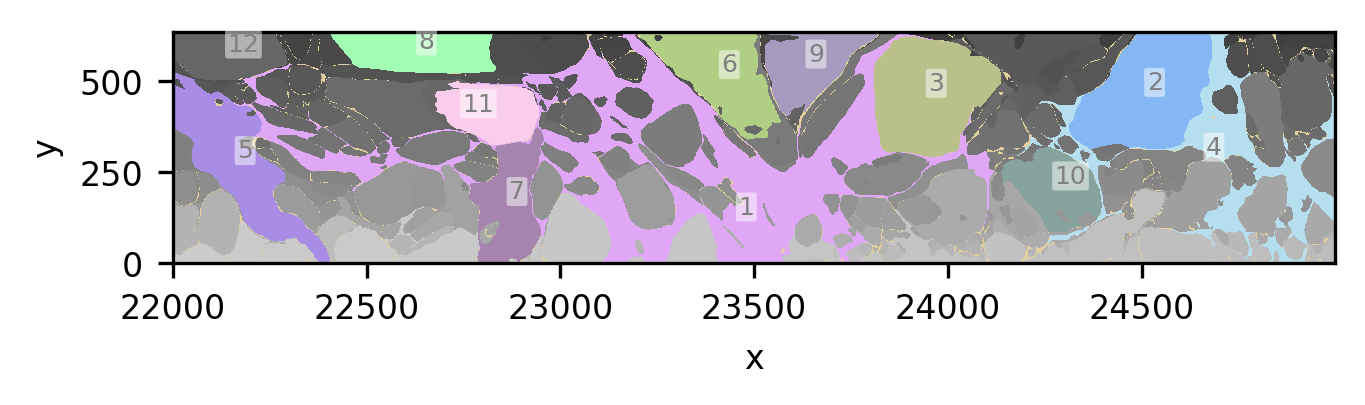

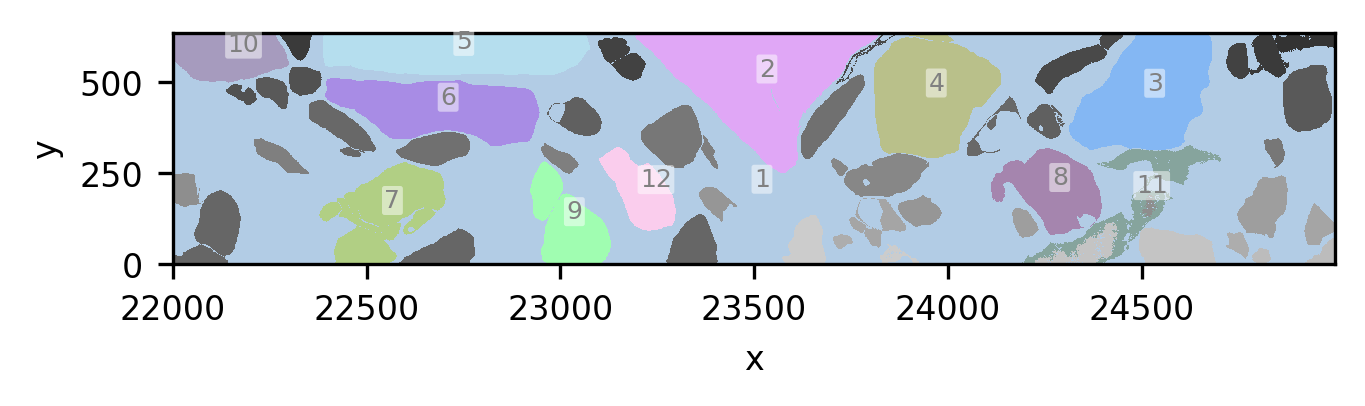

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from skimage.measure import regionprops, label
from skimage.measure import label as skilabel
from skimage.morphology import remove_small_objects

from collections import Counter
import xarray as xr

def plot_segmented_image(da_seg, ax, num_largest_segments=10, seed=16, top_exclude=0, offset=1, mode='skimage'):
    """
    Plots the segmented image onto the provided axis, highlighting the largest segments in color
    and others in grayscale. Also labels the largest segments.

    Parameters:
    - seg: 2D NumPy array of segmentation labels.
    - ax: Matplotlib axis to plot on.
    - num_largest_segments: Number of largest segments to highlight in color.
    - seed: Random seed for color generation.

    Returns:
    - im: The image object plotted on the axis.
    """
    # Compute counts of labels
    seg = da_seg.to_numpy().astype(int)
    ### map all segments labels to 1, 2, 3, 4 ...
    seg = skilabel(seg, background=0, )
    if mode == 'skimage':
        seg = remove_small_objects(seg, min_size=1000, connectivity=1)
    else:
        seg = remove_small_objects(seg, min_size=100, connectivity=1)
    ### fill the holes

    print(seg.max())

    counts = Counter(seg.flatten())
    # counts.pop(0, None)  # Remove background label 0 if present

    # Get labels of the largest segments
    largest_labels = [label for label, count in counts.most_common(num_largest_segments)]
    largest_labels = largest_labels[top_exclude:top_exclude+num_largest_segments]

    other_labels = set(np.unique(seg)) - set([0]) - set(largest_labels)
    n_other_labels = len(other_labels)

    # Create label to colormap index mapping
    label_to_cmap_index = {0: 0}  # Background label
    for idx, label in enumerate(largest_labels, start=1):
        label_to_cmap_index[label] = idx

    # Assign grayscale indices to other labels
    total_labels = len(np.unique(seg))

    N_grayscale = total_labels - num_largest_segments
    N_grayscale = N_grayscale // 2
    grayscale_indices = np.linspace(len(largest_labels)+1, len(largest_labels)+N_grayscale, n_other_labels, dtype=int)
    for label, grayscale_idx in zip(sorted(other_labels), grayscale_indices):
        label_to_cmap_index[label] = grayscale_idx

    # Create the colormap
    cmap_size = len(largest_labels) + N_grayscale + 1
    colors = np.zeros((cmap_size, 3))

    # Background color
    #colors[1] = [0.3, 0.3, 0.3]  # Background color
    
    np.random.seed(seed)
    # Colors for largest segments using random colors
    n_labels = len(largest_labels)
    rand_colors = np.random.rand(n_labels, 3) 
    pastel_colors = (rand_colors + np.ones((n_labels, 3))) / 2  # Blend with white for pastel
    #pastel_colors[] = [0.3, 0.3, 0.3]  # Set background (label 0) to a light gray

    largest_label_colors = pastel_colors
    #largest_label_colors = np.random.rand(len(largest_labels), 3) * 0.7 + 0.3  # Blend with white for pastel
    for idx in range(len(largest_labels)):
        colors[idx] = largest_label_colors[idx][:3]

    if mode == 'skimage':
        colors[0] = [1, 1, 1]
        colors[0] = [.7, .8, .9]  # Background color


    colors[idx+1] = [0.4, 0.4, 0.4]  # Background color

    # Grayscale colors for other segments
    grayscale_values = np.linspace(0.8, 0.2, N_grayscale)
    for idx in range(N_grayscale):
        colors[len(largest_labels)+1 + idx] = [grayscale_values[idx]] * 3

    cmap = ListedColormap(colors)

    # Map 'seg' to 'seg_mapped' using the label to colormap index mapping
    max_label = seg.max()
    label_map = np.zeros(max_label + 1, dtype=int)
    for label, idx in label_to_cmap_index.items():
        label_map[label] = idx
    seg_mapped = label_map[seg]

    # Plot the segmentation
    #seg_mapped[seg_mapped == 0] = 
    seg_mapped_da = xr.DataArray(seg_mapped, dims=('y', 'x'), coords={'y': da_seg.y, 'x': da_seg.x})
    im = seg_mapped_da.plot.imshow(cmap=cmap, add_colorbar=False, ax=ax)

    # include the offset of the image


    # Assign the label 1 to the largest segment and increase the label number for each new segment
    # Assign the label 1 to the largest segment and increase the label number for each new segment
    largest_labels_sorted = sorted(largest_labels, key=lambda label: counts[label], reverse=True)
    label_mapping = {label: idx + offset for idx, label in enumerate(largest_labels_sorted)}
    rect_color = cmocean.cm.ice(0.1)
    textsize = 6 if num_largest_segments > 30 else 4

    regions = regionprops(seg)

    print(label_mapping)

    for region in regions:
        label = region.label
        if label in largest_labels:
                        
            minr, minc, maxr, maxc = region.bbox
            # add the offset of the image
            minr += da_seg.y.min()
            maxr += da_seg.y.min()
            minc += da_seg.x.min()
            maxc += da_seg.x.min()

            # do it with the centroid
            x_text = region.centroid[1] + da_seg.x.min()
            y_text = region.centroid[0] + da_seg.y.min()


            # if (label_mapping[label] == 9) & (mode == 'skimage'):
            #     pass
            if (mode == 'sam'):

                if label_mapping[label] == 1:
                    y_text -= 150
                    x_text += 150
                if label_mapping[label] == 4:
                    x_text -= 50
                if label_mapping[label] == 11:
                    x_text -= 70
                    y_text -= 10


                
            edgecolor = colors[label_to_cmap_index[label]]
            #rect = Rectangle((minc, minr), maxc - minc, maxr - minr,
            #                 edgecolor=rect_color, facecolor='none', linewidth=1, alpha=0.4)
            #ax.add_patch(rect)
            # Write the label number
            #x_text = minc + (maxc - minc) / 2
            #y_text = minr + (maxr - minr) / 2
            ax.text(x_text, y_text, str(label_mapping[label]), color='gray', fontsize=6, ha='left', va='bottom',
                    bbox=dict(facecolor='w', edgecolor='none', alpha=0.5, 
                              boxstyle='round,pad=0.1'))
         
    if (mode == 'skimage'):
        ax.text(23500, 200, 1, color='gray', fontsize=6, ha='left', va='bottom',
        bbox=dict(facecolor='w', edgecolor='none', alpha=0.5, 
                    boxstyle='round,pad=0.1'))

    print(len(largest_labels))
    ax.axes.grid(False)
    return im


fig, ax = plt.subplots(1, 1, figsize=(5, 1))
seed = 46
plot_segmented_image(ds['segmentation'], ax, num_largest_segments=12, seed=seed, top_exclude=0, offset=1, mode='sam')
fig, ax = plt.subplots(1, 1, figsize=(5, 1))
plot_segmented_image(ds['skimage_seg'], ax, num_largest_segments=12, seed=seed, top_exclude=0, offset=1, mode='skimage')

In [13]:
ds_gp_mean = ds[['BT_5', 'BT_1', 'BT_6', 'segmentation']].groupby('segmentation').median()
ds_gp_std = ds[['BT_5', 'BT_1', 'BT_6', 'segmentation']].groupby('segmentation').std()


<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_702851/1340003886.py:56: SyntaxWarning: invalid escape sequence '\m'
  cbar = fig.colorbar(im, cax=cax, orientation='vertical', label='$T_\mathrm{B,1}$ (°C)', ticks=[-20, -15, -10, -5])


4076
{37: 1, 2208: 2, 2007: 3, 88: 4, 15: 5, 2409: 6, 25: 7, 3298: 8, 2748: 9, 794: 10}
10
974
{0: 1, 740: 2, 851: 3, 820: 4, 936: 5, 859: 6, 2: 7, 464: 8, 4: 9, 924: 10}
10


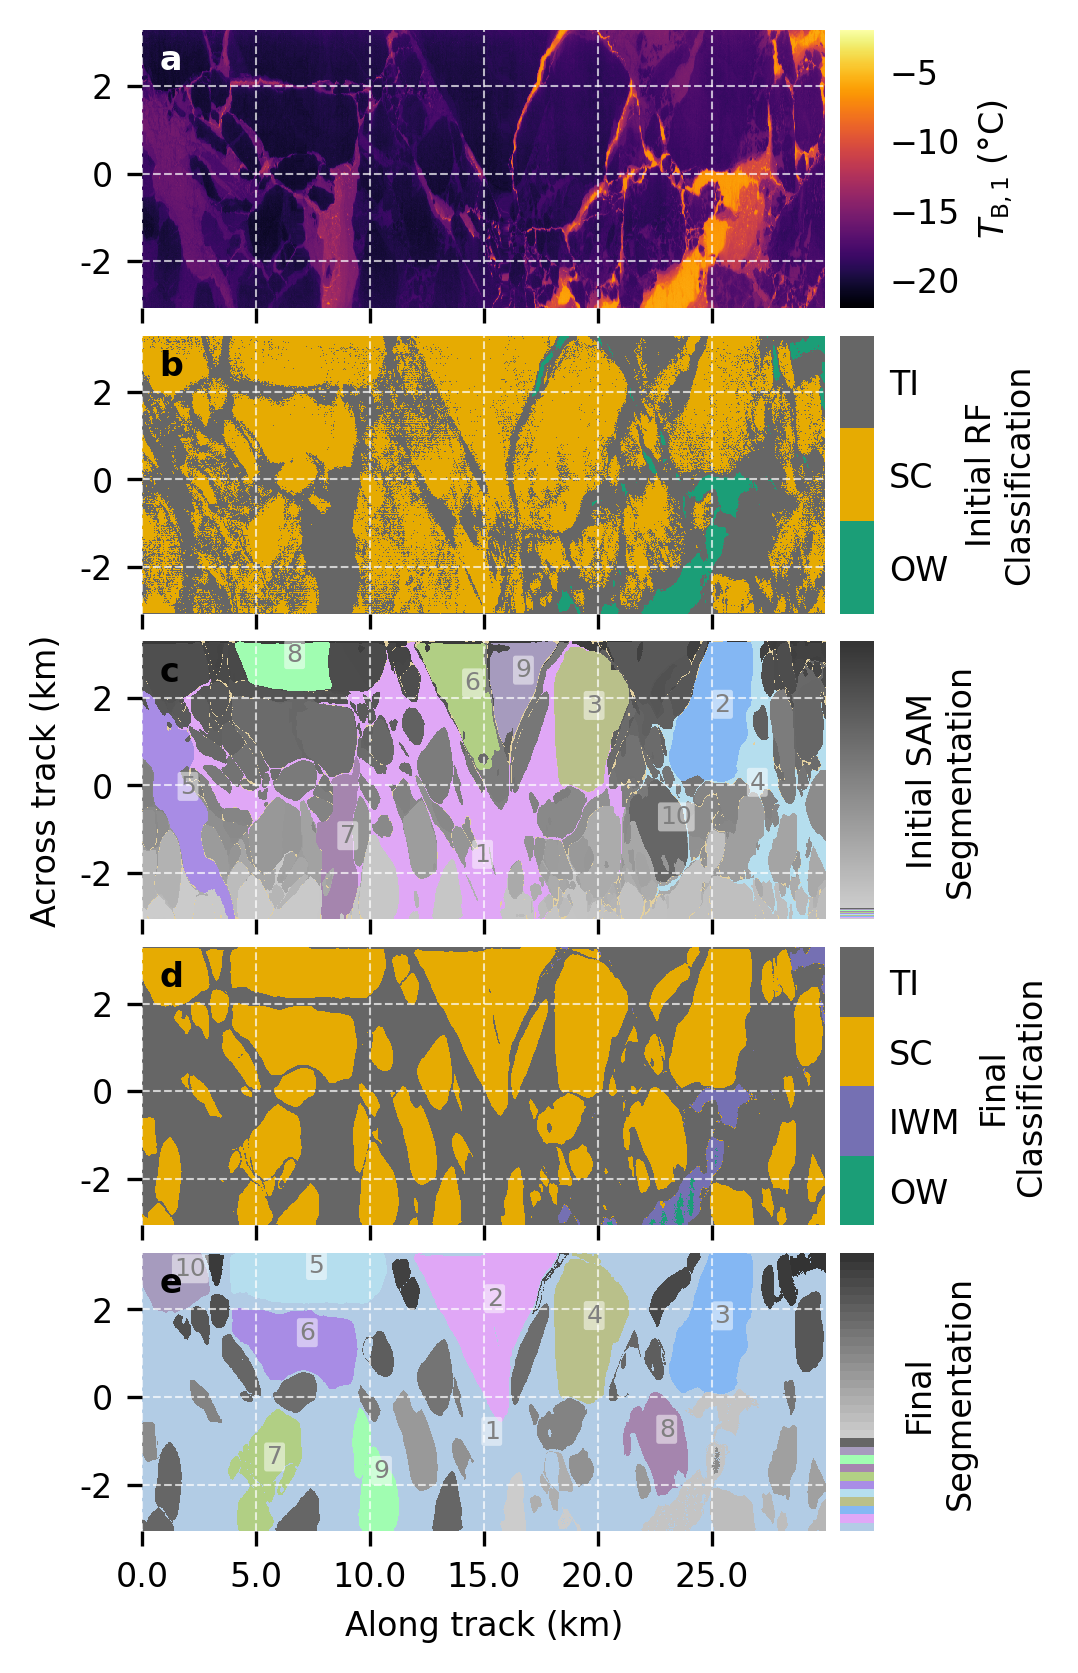

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from skimage.measure import label
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import json

plt.rcParams.update(json.load(open('/projekt_agmwend/home_rad/Joshua/MasterArbeit/plot_settings.json')))


fs = 8
plt.rcParams['font.size'] = fs
plt.rcParams['axes.titlesize'] = fs
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['legend.fontsize'] = fs
plt.rcParams['figure.titlesize'] = fs


colors = np.array([[0.10588235, 0.61960784, 0.46666667, 1.],
                #[0.45882353, 0.43921569, 0.70196078, 1.],
                [0.90196078, 0.67058824, 0.00784314, 1.],
                [0.4       , 0.4       , 0.4       , 1.],

])

cmap = ListedColormap(colors)
#cmap = plt.get_cmap('Dark2')
bounds = [1, 2, 4, 5]
norm = BoundaryNorm(bounds, cmap.N)


# Generate random RGB values for each segment
def random_cmap(nlabels, seed=12):
    np.random.seed(seed)
    rand_colors = np.random.rand(nlabels, 3)
    pastel_colors = (rand_colors + np.ones((nlabels, 3))) / 2  # Blend with white for pastel
    pastel_colors[0] = [0.3, 0.3, 0.3]  # Set background (label 0) to a light gray
    return ListedColormap(pastel_colors)

# Assuming 'image' is your input data
image = ds['smoothed_prediction']
seg = label(image.to_numpy(), background=4)
seg2 = ds['segmentation'].to_numpy()

ds['skimage_seg'] = xr.DataArray(seg, dims=('y', 'x'))

fig, ax = plt.subplots(5, 1, figsize=(3.15, 6.5), sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

im = ds['BT_1'].plot(ax=ax[0], cmap='inferno', add_colorbar=False, vmin=-2, vmax=-20)  
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', label='$T_\mathrm{B,1}$ (°C)', ticks=[-20, -15, -10, -5])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(which='both', length=0)
cbar.ax.grid(False)

# Plot 1: Old prediction contour
im = ds['old_prediction'].plot(cmap=cmap, norm=norm, add_colorbar=False, ax=ax[1])
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[1.5, 3, 4.5], label='Initial RF\nClassification')
cbar.set_ticklabels(['OW', 'SC', 'TI'])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(which='both', length=0)
cbar.ax.grid(False)

im = plot_segmented_image(ds['segmentation'], ax[2], num_largest_segments=10, seed=seed, top_exclude=0, offset=1, mode='sam')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=np.arange(0, n_labels, 1000), label='Initial SAM\nSegmentation')
cbar.set_ticklabels([])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(which='both', length=0)

# Plot 3: Smoothed prediction contour
im = ds['smoothed_prediction'].plot.contourf(levels=[0.5, 1.5, 2.5, 3.5, 4.5], cmap='Dark2', add_colorbar=False, ax=ax[3])
divider = make_axes_locatable(ax[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[1, 2, 3, 4], label='Final\nClassification')
cbar.set_ticklabels(['OW', 'IWM', 'SC', 'TI'])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(which='both', length=0)
cbar.ax.grid(False)


y_ticks = np.array([306-300, 306-200, 306-100, 306, 306+100, 306+200, 306+300])
y_labels = np.array([-3, -2, -1, 0, 1, 2, 3])
y_ticks = np.array([306-200, 306,306+200])
y_labels = np.array([-2, 0, 2])

x_ticks_major = np.arange(22000, 25000, 500)
x_ticklabels = (x_ticks_major - 22000) / 100

for a in ax:
    a.set_yticks(y_ticks)
    a.set_yticklabels(y_labels)
    a.set_xticks(x_ticks_major)
    a.set_xticklabels(x_ticklabels)
    a.set_ylabel('')
    a.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    a.grid(True, axis='both', linestyle='--', alpha=0.7, color='w', zorder=111)
### add the a,b,c,d labels

fs = 8


im = plot_segmented_image(ds['skimage_seg'], ax[4], num_largest_segments=10, seed=seed, top_exclude=0, offset=1, mode='skimage')
divider = make_axes_locatable(ax[4])
cax = divider.append_axes('right', size='5%', pad=0.05)
cax.set_frame_on(False)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', label='Final \nSegmentation')
cbar.set_ticklabels([])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(which='both', length=0)
cbar.ax.grid(False)


y_ticks = np.array([306-300, 306-200, 306-100, 306, 306+100, 306+200, 306+300])
y_labels = np.array([-3, -2, -1, 0, 1, 2, 3])
y_ticks = np.array([306-200, 306,306+200])
y_labels = np.array([-2, 0, 2])

x_ticks_major = np.arange(22000, 25000, 500)
x_ticklabels = (x_ticks_major - 22000) / 100

for a in ax:
    a.set_yticks(y_ticks)
    a.set_yticklabels(y_labels)
    a.set_xticks(x_ticks_major)
    a.set_xticklabels(x_ticklabels)
    a.set_ylabel('')
    a.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    a.grid(True, axis='both', linestyle='--', alpha=0.7, color='w', zorder=111)
### add the a,b,c,d labels

fs = 8

ax[0].text(.025, .95, 'a', transform=ax[0].transAxes, fontsize=fs, fontweight='bold', va='top', color='w')
ax[1].text(.025, .95, 'b', transform=ax[1].transAxes, fontsize=fs, fontweight='bold', va='top')
ax[2].text(.025, .95, 'c', transform=ax[2].transAxes, fontsize=fs, fontweight='bold', va='top')
ax[3].text(.025, .95, 'd', transform=ax[3].transAxes, fontsize=fs, fontweight='bold', va='top')
ax[4].text(.025, .95, 'e', transform=ax[4].transAxes, fontsize=fs, fontweight='bold', va='top')

ax[-1].set_xlabel('Along track (km)')
ax[2].set_ylabel('Across track (km)')  
#fig.supylabel('Across track (km)', x=0.05

#ax.axes.grid(True, axis='both', linestyle='--', alpha=0.7, color='w')
plt.savefig('../../../plots/methods_flowchart_josh_v7.png', bbox_inches='tight', dpi=300)

Text(0.05, 0.5, 'Across track (km)')

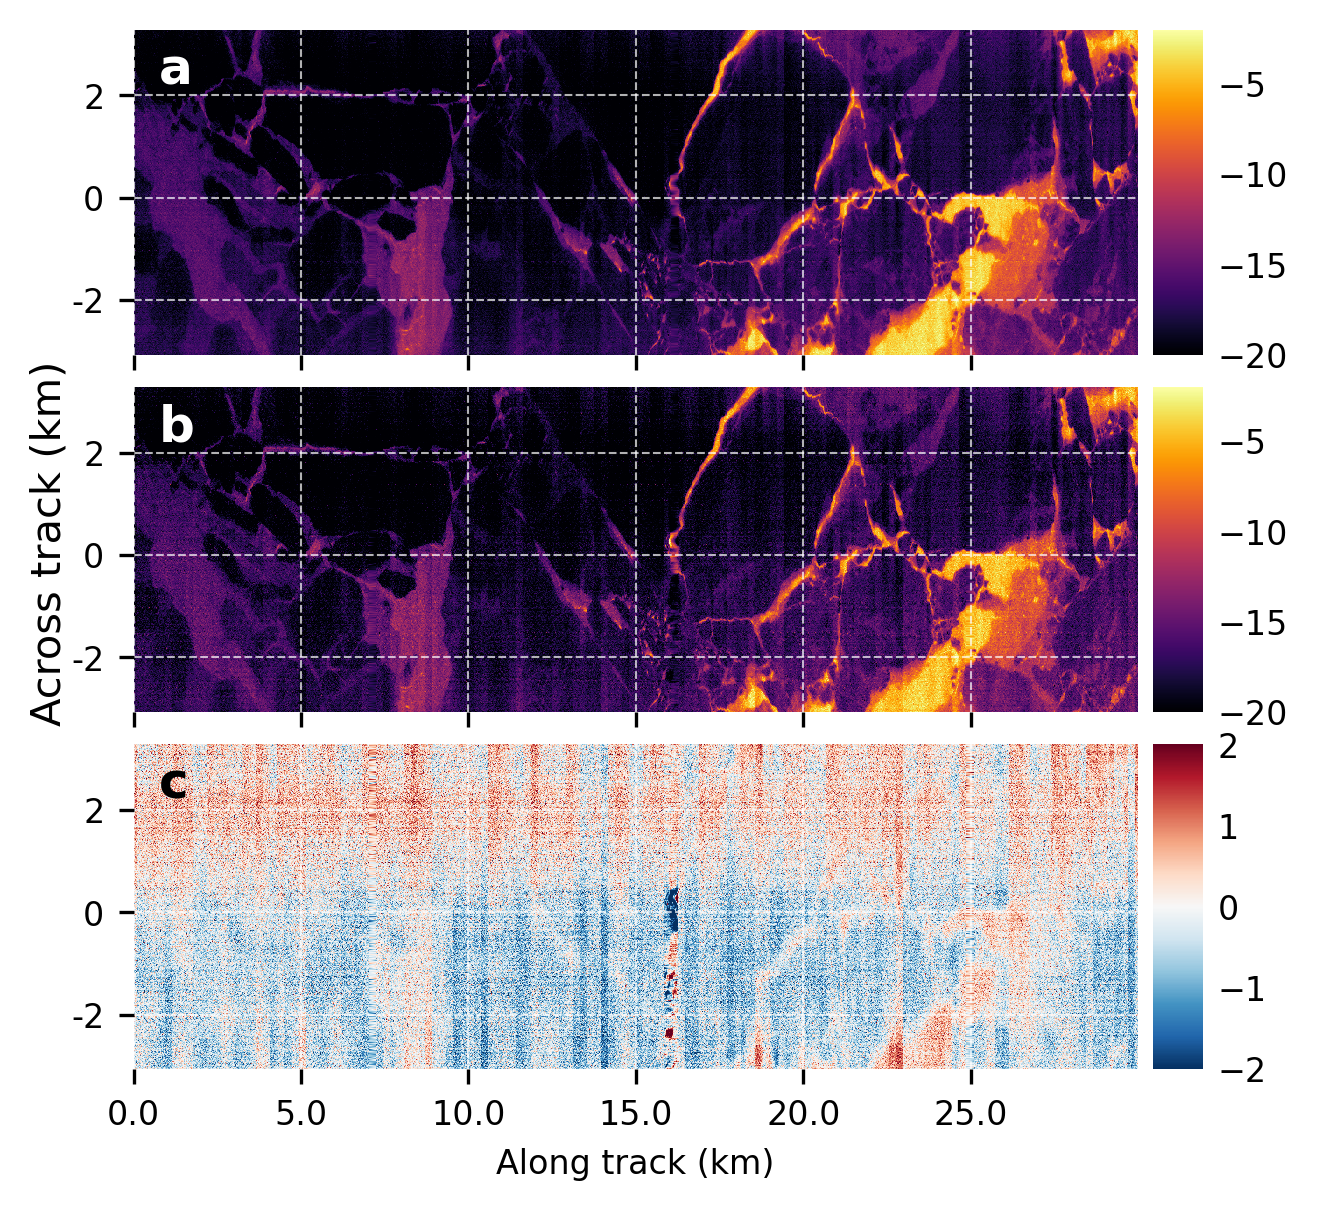

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(4.6, 4.5), sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.1, 'wspace': 0.1})



# Plot 1: BT5
im = (ds['BT_5'] + 1.4).plot(ax=ax[0], cmap='inferno', add_colorbar=False, vmin=-20, vmax=-2)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', label='', ticks=[-20, -15, -10, -5])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(which='both', length=0)
cbar.ax.grid(False)

# Plot 2: BT5 + (BT5 - BT6)
ds['split-window'] = 0.092 + 0.881 * ds['BT_5'] + 0.666 * (ds['BT_5'] - ds['BT_6'])
ds['split-window'].plot(ax=ax[1], cmap='inferno', add_colorbar=False, vmin=-20, vmax=-2)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', label='', ticks=[-20, -15, -10, -5])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(which='both', length=0)
cbar.ax.grid(False)

# Plot 3: Difference between BT5 and BT5 + (BT5 - BT6)
diff = 1.004* ds['BT_5'] - ds['split-window'] + 1.4
im = diff.plot(ax=ax[2], cmap='RdBu_r', add_colorbar=False, vmin=-2, vmax=2)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', label='')
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(which='both', length=0)
cbar.ax.grid(False)

# Set common labels and styling
y_ticks = np.array([306-200, 306, 306+200])
y_labels = np.array([-2, 0, 2])
x_ticks_major = np.arange(22000, 25000, 500)
x_ticklabels = (x_ticks_major - 22000) / 100

for a in ax:
    a.set_yticks(y_ticks)
    a.set_yticklabels(y_labels)
    a.set_xticks(x_ticks_major)
    a.set_xticklabels(x_ticklabels)
    a.set_ylabel('')
    a.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    a.grid(True, axis='both', linestyle='--', alpha=0.7, color='w', zorder=111)

# Add panel labels
fs = 12
ax[0].text(.025, .95, 'a', transform=ax[0].transAxes, fontsize=fs, fontweight='bold', va='top', color='w')
ax[1].text(.025, .95, 'b', transform=ax[1].transAxes, fontsize=fs, fontweight='bold', va='top', color='w')
ax[2].text(.025, .95, 'c', transform=ax[2].transAxes, fontsize=fs, fontweight='bold', va='top', color='k')

ax[-1].set_xlabel('Along track (km)')
fig.supylabel('Across track (km)', x=0.05, y=0.5, rotation=90, fontsize=10)

#plt.savefig('../../../plots/methods_flowchart_andre_v3_3panels.png', bbox_inches='tight', dpi=300)

/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "band" starting at index 4. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 202. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/xarray/core/dataset.py:275: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 202. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/xarray/core/dataset.py:275: UserW

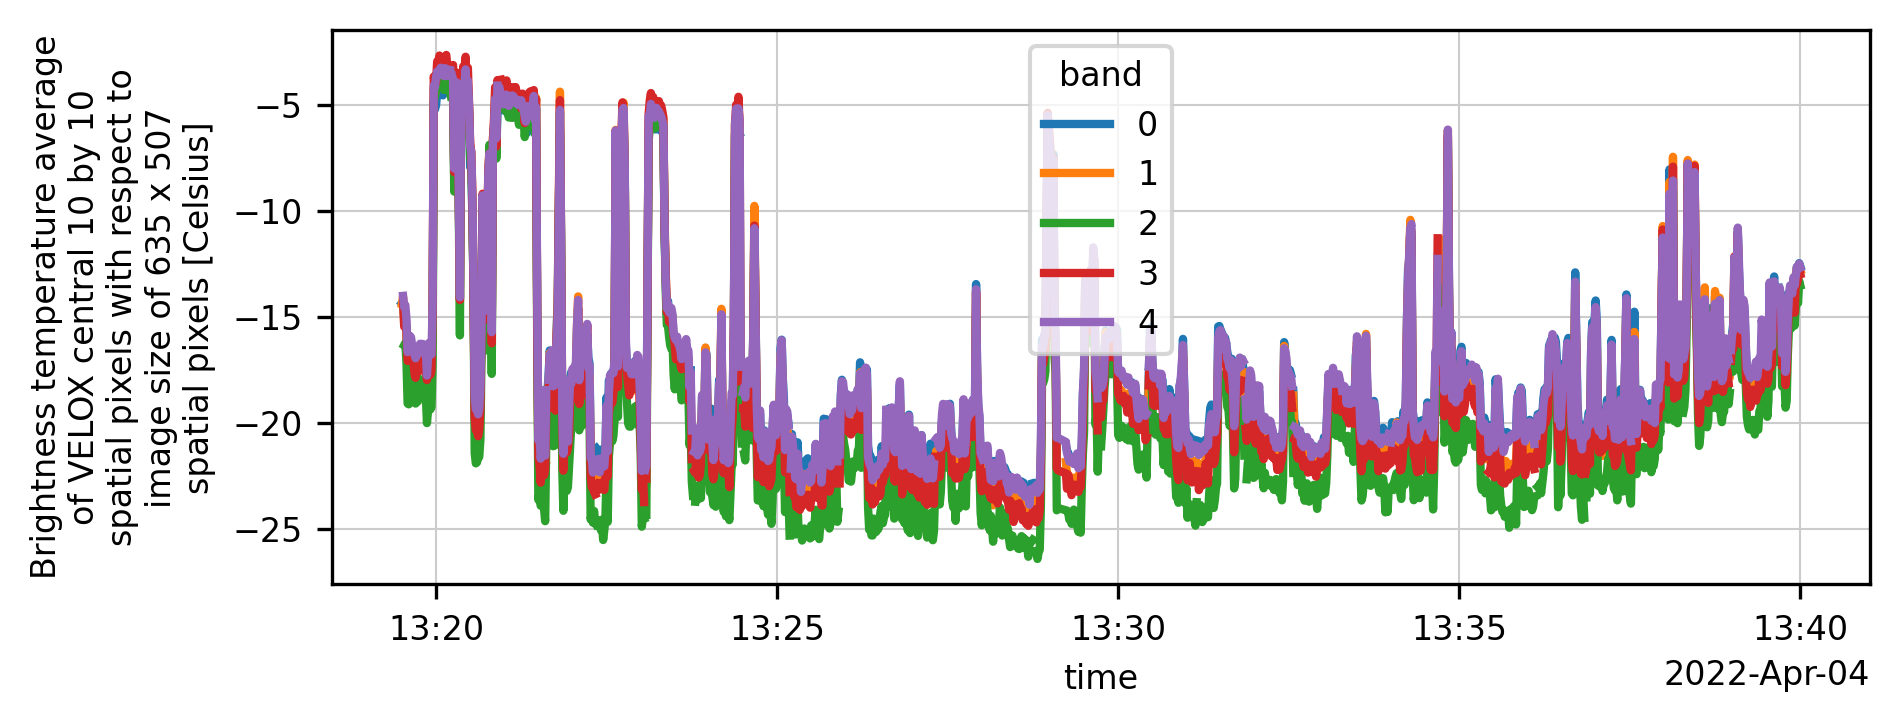

In [16]:
ds_raw = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/Mueller_et_al_2024/data/predicted/pushbroom/v_0.2/2022-04-04T13:19:30_2022-04-04T13:40:00.nc', engine='h5netcdf')
ds_raw['quality_flag'] = ds_raw.BT_1.isnull().sum(dim=('x', 'y')) == 0 

# ds_processed = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/Mueller_et_al_2024/data/predicted/pushbroom_to_publish/v_0.2/2022-03-20T13:19:30_2022-04-04T13:40:00.nc', engine='h5netcdf')
# ds_processed['quality_flag'] = ds_processed.skin_t.isnull().sum(dim=('x', 'y')) == 0

ds_raw_bt = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-04-04_v_0.1.zarr', engine='zarr', chunks='auto')
ds_raw_sel = ds_raw_bt.sel(time=slice('2022-04-04T13:19:30', '2022-04-04T13:40:00')).persist()
ds_raw_sel.BT_Center.plot(hue='band')
ds_raw_sel['quality_flag'] = ds_raw_sel.BT_2D.isel(band=0).isnull().sum(dim=('x', 'y')) == 0

ds_raw_sel['BT_5'] = ds_raw_sel.isel(band=3).BT_2D

In [17]:
import xarray as xr 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import dask.array as da
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import os
from helper import concatenate_images2


import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from skimage.measure import label
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import json


def concatenate_images_delayed(ds_sel, slicing_position, variable, quality_flag, pad_size):
    @delayed
    def concatenate_and_pad():
        im = concatenate_images2(ds_sel, slicing_position=slicing_position, variable=variable, quality_flag=quality_flag)
        im = im.astype(np.float32)
        im = np.pad(im, ((0, 0), (slicing_position, 0)), mode='constant', constant_values=np.nan)
        im = np.pad(im, ((0, 0), (0, pad_size)), mode='constant', constant_values=np.nan)
        return im
    
    return concatenate_and_pad()

def average_concat_dask(ds_sel, variable='label', slicing_positions=np.arange(0, 500, 30)):
    quality_flag = ds_sel['quality_flag'].values
    tasks = [concatenate_images_delayed(ds_sel, sp, variable, quality_flag, slicing_positions[-(i+1)])
             for i, sp in enumerate(slicing_positions)]
    with ProgressBar():
        results = compute(*tasks)
    ### check if all images have the same shape and remove the ones that don't

    shapes = [r.shape for r in results]
    if len(set(shapes)) > 1:
        print('Warning: Some images have different shapes')
        results = [r for r in results if r.shape == shapes[0]]

    ds_cc = da.stack(results, axis=0)
    
    return ds_cc
    #return da.nanmedian(ds_cc, axis=0).compute()
bt5 = average_concat_dask(ds_raw_sel, variable='BT_5',slicing_positions=np.arange(0, 500, 10))

[########################################] | 100% Completed | 338.25 s


In [18]:
bt5

dask.array<stack, shape=(49, 635, 26954), dtype=float32, chunksize=(1, 635, 26954), chunktype=numpy.ndarray>

In [19]:
ds_cc = xr.DataArray(bt5, dims=('vza','y', 'x'), coords={'vza' : np.arange(bt5.shape[0]),'y': np.arange(bt5.shape[1]), 'x': np.arange(bt5.shape[2])})

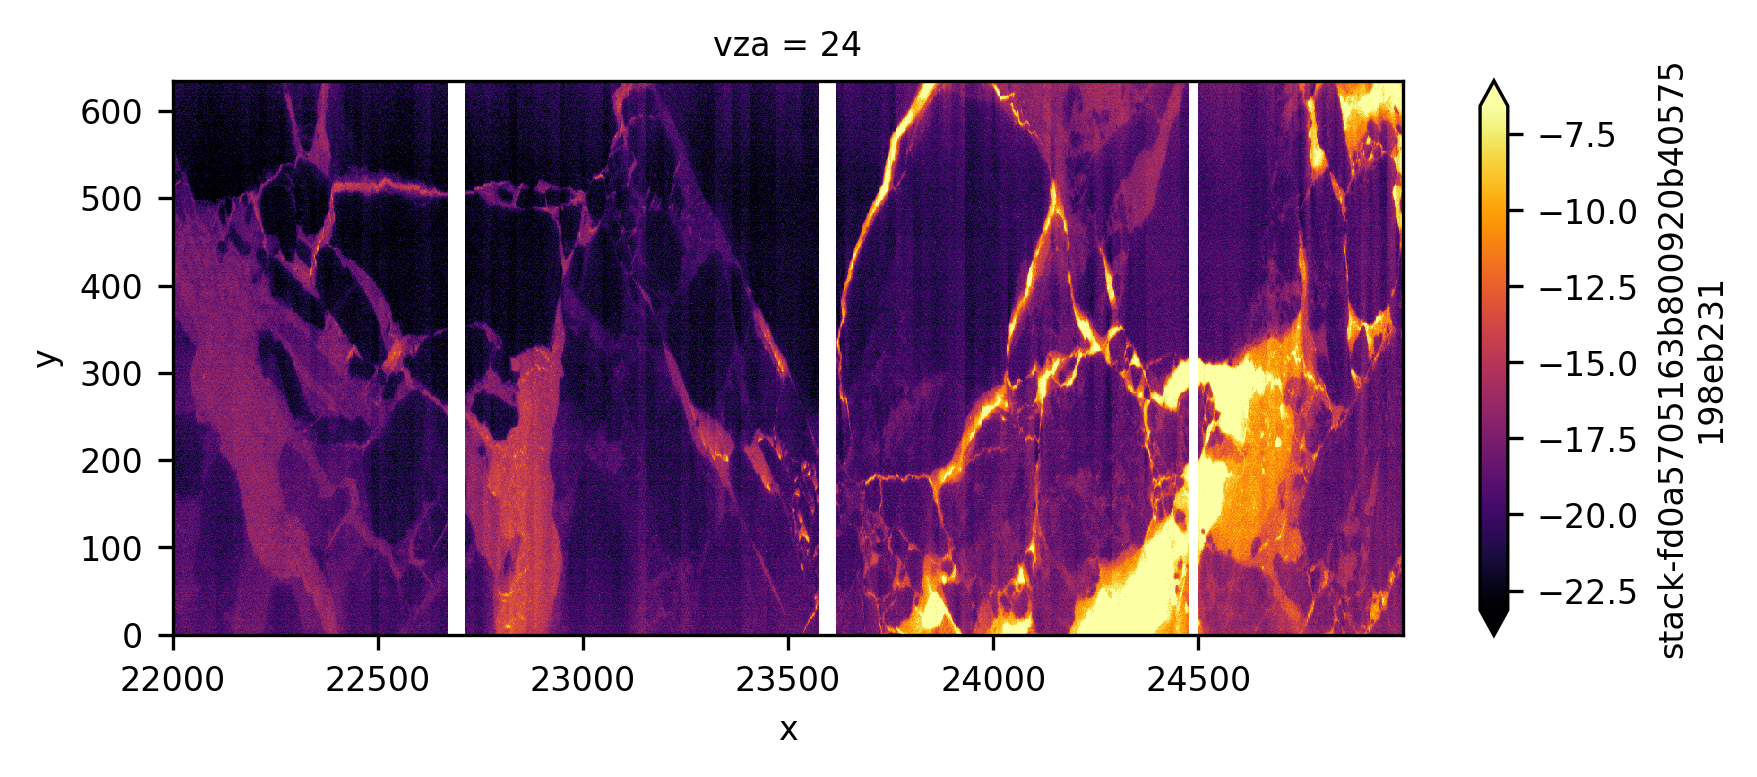

In [20]:
ds_cc.isel(x=slice(22000, 25000)).isel(vza=24).plot(cmap='inferno', robust=True)

In [21]:
ds_cc.std(dim='vza').mean().compute()

<xarray.DataArray 'stack-fd0a5705163b800920b40575198eb231' ()>
array(1.2844161, dtype=float32)

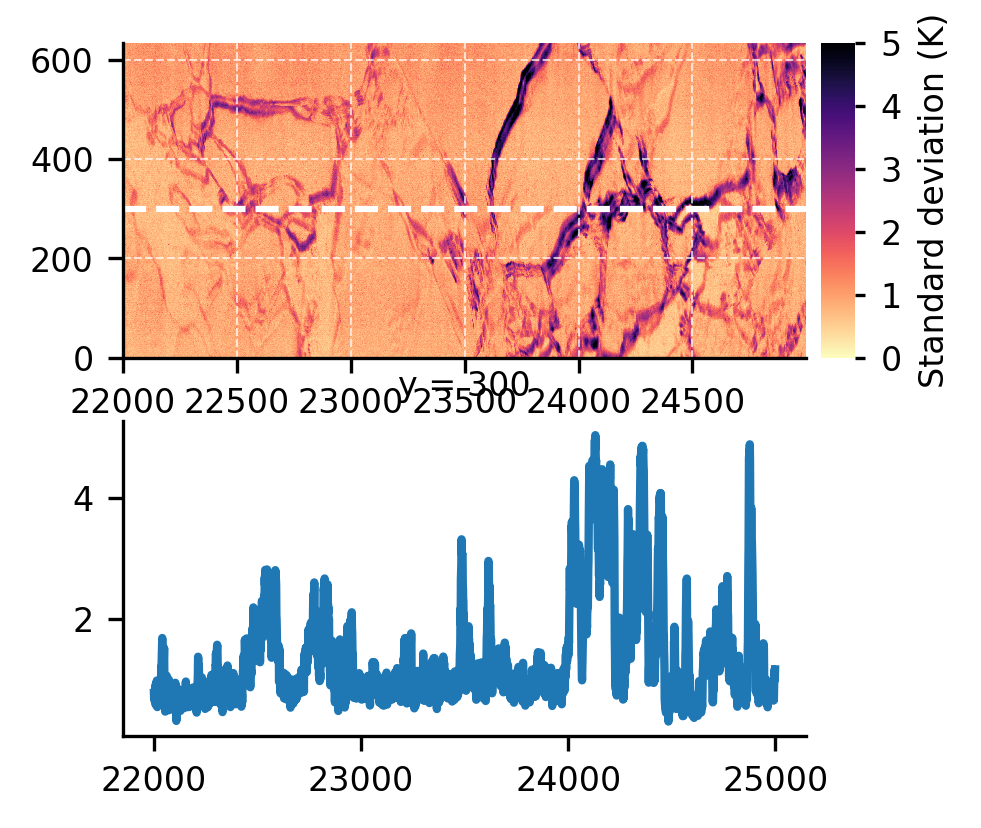

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(3.15, 3))

im = ds_cc.isel(x=slice(22000, 25000)).std(dim='vza').plot(robust=True, cmap='magma_r', vmin=0, vmax=5, ax=ax[0], add_colorbar=False)
ds_cc.isel(x=slice(22000, 25000)).std(dim='vza').isel(y=300).plot(ax=ax[1])

ax[0].axhline(300, color='w', linestyle='--', lw=1.5)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
divider = make_axes_locatable(ax[1])
cax2 = divider.append_axes('right', size='5%', pad=0.05)
cax2.remove()

cbar = fig.colorbar(im, cax=cax, orientation='vertical', label='Standard deviation (K)', ticks=[0, 1, 2, 3, 4, 5])
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(which='both', length=2.5)
cbar.ax.grid(False)

for a in ax:
    a.set_ylabel('')
    a.set_xlabel('')
    a.spines[['top', 'right']].set_visible(False)
    a.grid(True, axis='both', linestyle='--', alpha=0.7, color='w', zorder=111)

(0.0, 1.0, 0.0, 1.0)

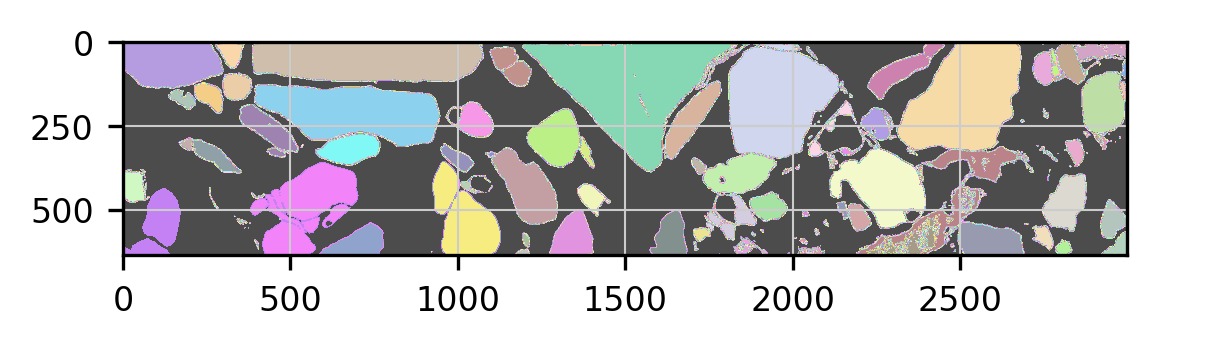

In [23]:
fig, ax = plt.subplots(figsize=(4.6, 6), sharex=True)

im = ax.imshow(seg[::-1,:], cmap=random_rgb_cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cax.axis('off')  # No colorbar